In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple
import numdifftools as nd
import sympy as sp
from iminuit import Minuit
from iminuit.cost import LeastSquares
import tabulate

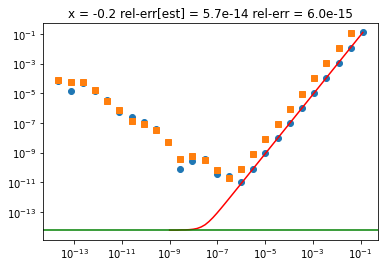

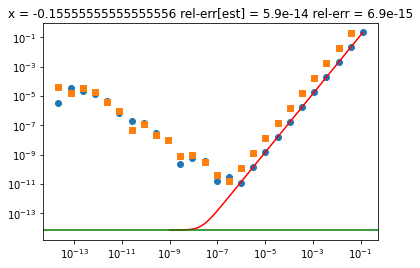

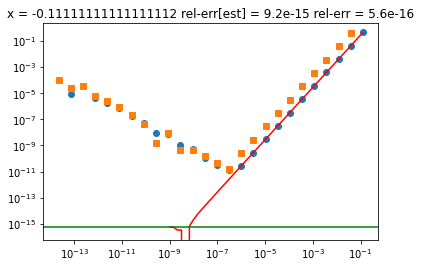

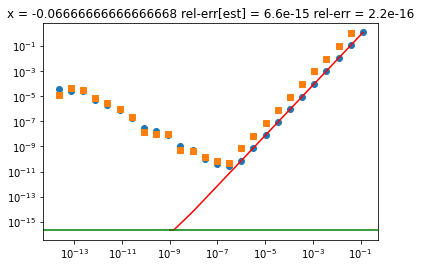

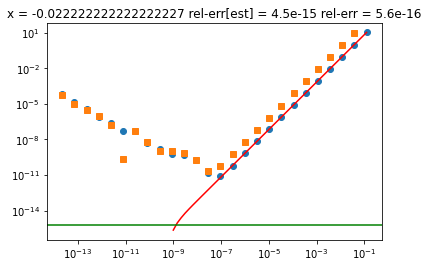

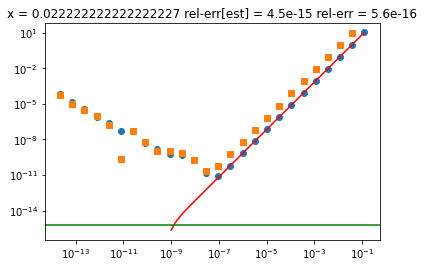

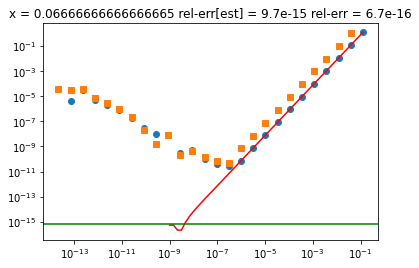

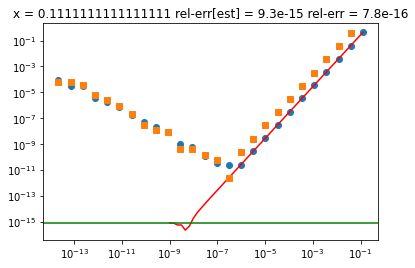

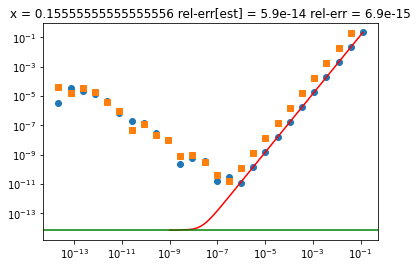

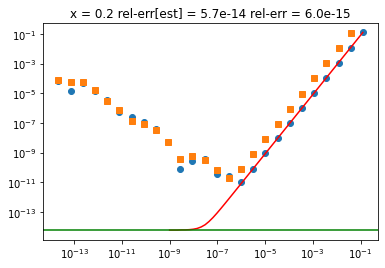

In [74]:
def fodd(f, x, p):
    return 0.5 * (f(x, p) - f(x, -p))


def central(f, x, p, h):
    hinv = 1.0 / h
    return fodd(f, x, p + h) * hinv


def f(x, p):
#     return np.exp((x + p).astype(np.float32))
#     return np.exp(x + p)
#     return (x + p) ** -10
    return ((x + p) ** 3)


def fpt(x):
#     return -10 * x ** -11
#     return np.exp(x)
    return 3 * x ** 2


def steps(p, h0=0.125, factor=0.5 / 1.618033988749895):
    eps = np.finfo(float).resolution
    h = p * h0
    if h == 0:
        h = h0
    n = int(np.log(eps / h0 ** 2) / np.log(factor)) + 1    
    return h * factor ** np.arange(n)


x = np.linspace(-0.2, 0.2, 10)
p = 0.0

eps = np.finfo(float).resolution

results = []
for hi in steps(p):
    fdi = central(f, x, p, hi)
    results.append((hi, fdi))
    
for i in range(len(x)):
    
    def reldev(fx):
        return np.abs(fx / fpt(x[i]) - 1)

    fddev = []
    fd = []
    h = []
    for hi, fdi in results:
        h.append(hi)
        fd.append(fdi[i])
        fddev.append(reldev(fdi[i]))

    h = np.array(h)
    
    plt.figure()
    plt.plot(h, fddev, "o")
    plt.loglog()

    n = 4
    p_est, C = np.polyfit(h[:n+1] ** 2, fd[:n+1], n - 1,
                          rcond=None, cov=True)
    hm = np.geomspace(1e-9, h[0])
    plt.plot(hm, reldev(np.polyval(p_est, hm ** 2)),
             color="r")
    plt.axhline(reldev(p_est[-1]), color="g")
    p_err = 10 * np.diag(C) ** 0.5
    plt.title(f"x = {x[i]} "
              f"rel-err[est] = {p_err[-1] / p_est[-1]:.1e} "
              f"rel-err = {reldev(p_est[-1]):.1e}")
    plt.plot(h[1:], np.abs(np.diff(fd)) / fpt(x[i]), "s")
    plt.loglog()

In [158]:
def central(f, x, p, h):
    return fodd(f, x, p + h) * (1.0 / h)


def _steps(p, h0=0.125, factor=0.5):
    eps = np.finfo(float).resolution
    h = p * h0
    if h == 0:
        h = h0
    n = int(np.log(eps / h0 ** 2) / np.log(factor)) + 1    
    return h * factor ** np.arange(n)


def vjacobi(f, x, p, rtol=None, maxiter=None):
    x = np.atleast_1d(x)

    shape = np.shape(x)

    h = _steps(p)
    todo = np.ones(shape, dtype=bool)
    
    eps = np.finfo(float).resolution
    if rtol is None:
        rtol = eps
    else:
        assert rtol >= 0

    fd = []
    for i, hi in enumerate(h):
        fdi = central(f, x[todo], p, hi)
        fd.append(fdi)

        if i == 0:
            f_shape = np.shape(fdi)
            # maybe this can be relaxed later
            assert f_shape == shape
            r = np.empty(f_shape)
            re = np.full(f_shape, np.inf)
            r[:] = fdi
            continue
        
        # polynomial fit with one extra degree of freedom
        grad = min(i - 1, 3)
        start = i - (grad + 1)
        stop = i + 1
        q, C = np.polyfit(h[start:stop] ** 2, fd[start:], grad,
                           rcond=None, cov=True)
        ri = q[-1]
        # pulls have roughly unit variance, however, 
        # the pull distribution is not gaussian and looks
        # more like student's t
        rei = C[-1, -1] ** 0.5
        
        # update estimates that have improved (smaller error)
        sub_todo = (rei < re[todo])
        todo1 = todo.copy()
        todo[todo1] = sub_todo
        r[todo] = ri[sub_todo]
        re[todo] = rei[sub_todo]

        if maxiter and i >= maxiter:
            break

        # do not improve estimates further which meet the tolerance
        sub_todo &= (rei > rtol * np.abs(ri))
        todo[todo1] = sub_todo

#         print("dev", r / (3 * x ** 2) - 1)
#         print("est", re / np.abs(r))
#         print(todo)
    
        if np.sum(todo) == 0:
            break

        # shrink previous vectors of estimates
        fd = [fdi[sub_todo] for fdi in fd]

    re = np.maximum(re, np.abs(r) * eps)
    return r, re

x = np.linspace(-10, 10, 5)

def f(x, p):
    return np.exp(x + p)

def fpt(x):
    return np.exp(x)

print("exp(x)")
fp, fpe = vjacobi(f, x, p)
print(tabulate.tabulate([
    ["est  rel-err"] + list(fpe / np.abs(fp)),
    ["true rel-err"] + list(fp / fpt(x) - 1),
], tablefmt="presto", floatfmt=".1e"))

def f(x, p):
    return (x + p) ** 3

def fpt(x):
    return 3 * x ** 2

print("x^3")
x = np.linspace(-0.0001, 0.0001, 6)
fp, fpe = vjacobi(f, x, p)
print(tabulate.tabulate([
    ["value"] + list(fp),
    ["est  rel-err"] + list(fpe / np.abs(fp)),
    ["true rel-err"] + list(fp / fpt(x) - 1),
], tablefmt="presto", floatfmt=".1e"))

exp(x)
 est  rel-err |  1.2e-15 |  3.3e-15 |  3.8e-15 | 4.4e-15 | 8.5e-15
 true rel-err | -1.1e-14 | -1.5e-14 | -2.1e-14 | 8.9e-16 | 8.4e-15
x^3
 value        |  3.0e-08 |  1.1e-08 |  1.2e-09 |  1.2e-09 |  1.1e-08 |  3.0e-08
 est  rel-err |  6.1e-13 |  2.6e-14 |  2.4e-11 |  2.4e-11 |  2.6e-14 |  6.1e-13
 true rel-err | -1.8e-11 | -3.0e-13 | -7.4e-10 | -7.4e-10 | -3.0e-13 | -1.8e-11


In [159]:
vjacobi(lambda x, p: (x + p) ** 3, 1e-10, 0)

(array([-8.61890155e-20]), array([2.29505769e-21]))

In [160]:
nd.Derivative(lambda p: p ** 3)(1e-10)

array(3.00294356e-20)

In [161]:
%%timeit -n 1 x = np.linspace(0, 10, 10000)
vjacobi(lambda x, p: np.exp(x + p), x, 0)

9.99 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [162]:
%%timeit -n 1 x = np.linspace(0, 10, 10000)
vjacobi(lambda x, p: np.exp(x + p), x, 0, rtol=1e-2)

1.28 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [163]:
%%timeit -n 1 -r 1 x = np.linspace(0, 10, 10000)
nd.Derivative(lambda p: np.exp(x + p))(0)

1.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


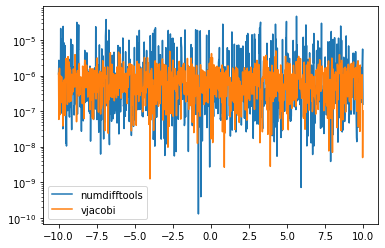

In [164]:
x = np.linspace(-10, 10, 1000)

fp1 = nd.Derivative(lambda p: np.exp(x + p).astype(np.float32))(0)
fp2 = vjacobi(lambda x, p: np.exp(x + p).astype(np.float32), x, 0)[0]

plt.plot(x, np.abs(fp1 / np.exp(x) - 1), label="numdifftools")
plt.plot(x, np.abs(fp2 / np.exp(x) - 1), label="vjacobi")
plt.semilogy()
plt.legend();

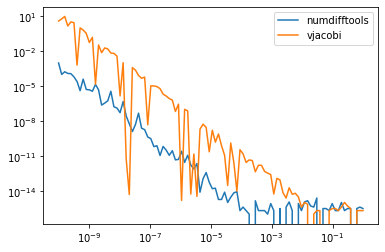

In [166]:
x = np.geomspace(1e-10, 1, 100)

fp1 = nd.Derivative(lambda p: (x + p) ** 3)(0)
fp2 = vjacobi(lambda x, p: (x + p) ** 3, x, 0)[0]

plt.plot(x, np.abs(fp1 / fpt(x) - 1), label="numdifftools")
plt.plot(x, np.abs(fp2 / fpt(x) - 1), label="vjacobi")
plt.loglog()
plt.legend();

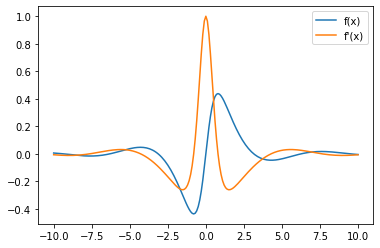

In [102]:
x = np.linspace(-10, 10, 201)

class F:
    nf = 0
    nx = 0

    def __init__(self, *args):
        if len(args) == 1:
            self.x, = args

    def __call__(self, *args):
        if len(args) == 2:
            x, p = args
        else:
            p, = args
            x = self.x
        self.nf += 1
        self.nx += len(x)
        y = (x + p)
        return np.sin(y)/(y**2 + 1)
    
f = F()
p = np.array([0.0])
# fx, fpx = vjacobi(f, x, p, dp=np.array([1e-9]), rtol=0, debug=1)
fpx, fpxe = vjacobi(f, x, p)

plt.plot(x, F()(x, 0), label="f(x)")
plt.plot(x, fpx, label="f'(x)")
plt.legend();

In [103]:
f = F(x)
fp1 = nd.Derivative(f)(0)
print(f.nf, f.nx, round(f.nx / len(x), 1))

30 6030 30.0


In [104]:
f = F()
fp2 = vjacobi(f, x, p)[0]
print(f.nf, f.nx, round(f.nx / len(x), 1))

18 2476 12.3


In [105]:
f = F()
fp3 = vjacobi(f, x, p, rtol=1e-3)[0]
print(f.nf, f.nx, round(f.nx / len(x), 1))

8 1006 5.0


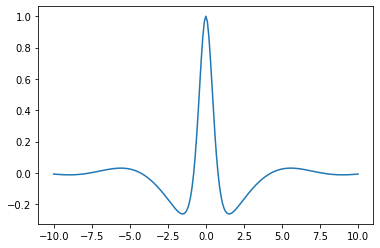

In [106]:
# compute exact derivative of sin(x)/x
fp = sp.lambdify("x", sp.diff("sin(x)/(x**2 + 1)").simplify(), "numpy")
plt.plot(x, fp(x));

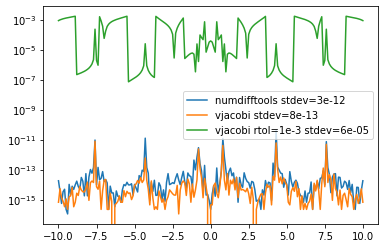

In [107]:
fpx = fp(x)
plt.plot(x, np.abs(fp1/fpx-1), label=f"numdifftools stdev={np.nanstd(fp1/fpx):.0e}")
plt.plot(x, np.abs(fp2/fpx-1), label=f"vjacobi stdev={np.nanstd(fp2/fpx):.0e}")
plt.plot(x, np.abs(fp3/fpx-1), label=f"vjacobi rtol=1e-3 stdev={np.nanstd(fp3-fpx):.0e}")
plt.semilogy()
plt.legend();

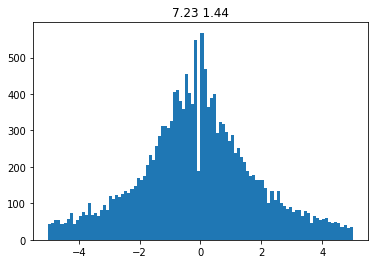

In [108]:
from scipy.stats import median_abs_deviation as mad

x = np.linspace(-10, 10, 20001)

fp1, fp1e = vjacobi(F(), x, 0)

pull = (fp1 - fp(x)) / fp1e
plt.hist(pull, bins=100, range=(-5,5));
plt.title(f"{np.std(pull):.2f} {mad(pull):.2f}");